# Hidden Markov Model

In [2]:
import pandas as pd
from datetime import datetime
from matplotlib import pyplot as plt
%matplotlib inline
from  statsmodels.tsa.stattools import adfuller,kpss 
import statsmodels.api
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_squared_log_error,balanced_accuracy_score
from statistics import mean
import statsmodels.api as sm
from sklearn import preprocessing
import seaborn as sns
import gapminder
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [22]:
#technical indicators:
def ema(x,window):
    '''exponential moving average'''
    return np.array(x.ewm(span=window).mean())


def bollinger(x,window):
    '''Bolinger bands & moving average'''
    rolling_mean = x.rolling(window).mean()
    rolling_std = x.rolling(window).std()
    roll_mean = rolling_mean
    higher_band = rolling_mean + (rolling_std * 2)
    lower_band = rolling_mean - (rolling_std * 2)
    return [lower_band[window:],roll_mean[window:],higher_band[window:]]


def macd(v): 
    '''moving average convergence divergence'''
    return ema(v,12)-ema(v,26)

def momentum(x,lags):
    return (1-x/x.shift(lags))*100

def a_d(close,low,high,vol):
    '''accumulation/distribution indicator''' 
    return ((close-low)-(high-close)*vol)/(high-low)

def trend_deterministic(dat):
    '''indicators which help to determine price direction, i.e. 1 stands for up, -1 for down'''
    dat['tr-ema']=np.where(dat['ema']<dat['mid'],1,-1)
    dat['tr-macd']=np.where(dat[['macd']]>dat[['macd']].shift(1),1,-1)
    dat['tr-momentum']=np.where(dat['momentum']>0,1,-1)
    return dat
        
def return_size(df):
    df['return']=df.loc[:,'close']-df.loc[:,'close'].shift(1)
    df['size']=np.nan
    for i in range(1,len(df['return'])): 
        if df['return'][i]>=0:
            df.iloc[i,-1]='P'#for positive
        if df['return'][i]<0 :
            df.iloc[i,-1]='N'#for negative
    df=df.dropna()
    return df

def plot_return(df):
    plt.figure(figsize=(15,2))
    plt.plot(df[['date']][:100],df[['return']][:100] )
    plt.title(str(df.name)+' Price Close')
    plt.xlabel('time')
    plt.ylabel('price')
    plt.subplot()
    
def plot_close(df):
    plt.figure(figsize=(15,2))
    plt.plot(df[['date']],df[['close']])
    plt.title(str(df.name)+' Price Close')
    plt.xlabel('time')
    plt.ylabel('price')
    plt.subplot()

def rename_col(df):
    df.columns=['date','time','open','high','low','close','vol']
    return df

def format_time(df):
    df['date']=df['date']+' '+df['time']
    df=df.drop(columns=['time'])
    df['date']=[datetime.strptime(i, '%d/%m/%y %H:%M:%S') for i in list(df['date'])]
    return df

#### Open and format data

In [26]:
day=pd.read_csv('C:\\Users\\Dell\\Desktop\\coursework\\Stonks-2\\AMZN_day.csv')
hour=pd.read_csv('C:\\Users\\Dell\\Desktop\\coursework\\Stonks-2\\AMZN_hour.csv')
minute=pd.read_csv('C:\\Users\\Dell\\Desktop\\coursework\\Stonks-2\\AMZN_min.csv')

minute=minute.iloc[:,2:]
hour=hour.iloc[:,2:]
day=day.drop(columns=['Adj Close'])

day.columns=['date','open','high','low','close','vol']
minute=rename_col(minute)
hour=rename_col(hour)

day['date']=[datetime.strptime(i, '%Y-%m-%d') for i in list(day['date'])]

minute=format_time(minute)
hour=format_time(hour)

day=return_size(day)
minute=return_size(minute)
hour=return_size(hour)

#https://www.eia.gov/dnav/pet/PET_PRI_SPT_S1_D.htm
day

,date,open,high,low,close,vol,return,size
1,2010-02-10,118.000000,118.610001,116.000000,117.360001,6233200,-0.669998,N
2,2010-02-11,117.209999,120.419998,116.500000,120.089996,8343500,2.729995,P
3,2010-02-12,118.989998,119.940002,117.500000,119.660004,8073500,-0.429992,N
4,2010-02-16,120.059998,120.500000,117.180000,117.529999,8932700,-2.130005,N
5,2010-02-17,117.070000,117.129997,115.550003,116.309998,8944800,-1.220001,N
...,...,...,...,...,...,...,...,...
2518,2020-02-11,2150.899902,2185.949951,2136.000000,2150.800049,5746000,16.890137,P
2519,2020-02-12,2163.199951,2180.250000,2155.290039,2160.000000,3334300,9.199951,P
2520,2020-02-13,2144.989990,2170.280029,2142.000000,2149.870117,3031800,-10.129883,N
2521,2020-02-14,2155.679932,2159.040039,2125.889893,2134.870117,2606200,-15.000000,N


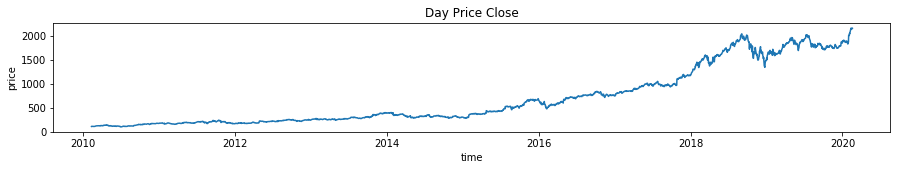

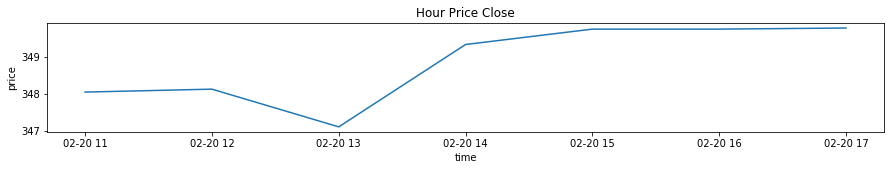

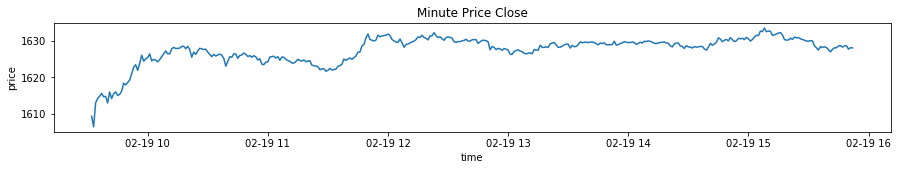

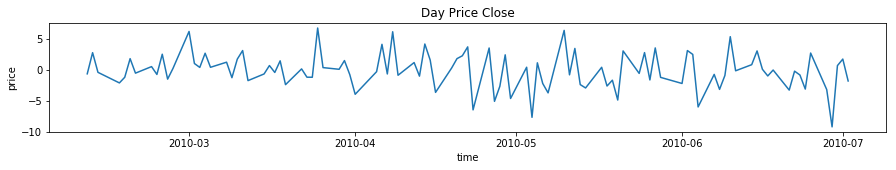

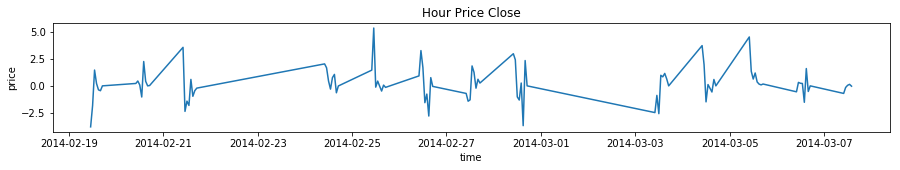

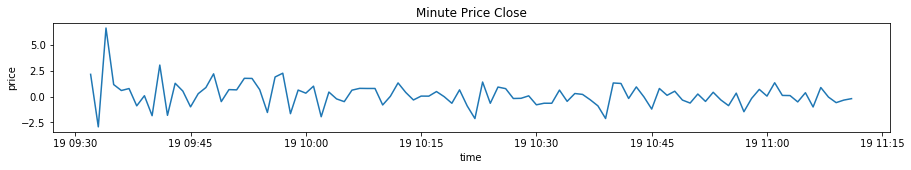

In [29]:
day.name='Day'
hour.name='Hour'
minute.name='Minute'

plot_close(day)
plt.figure(figsize=(15,2))
plt.plot(hour[['date']][8:15],hour[['close']][8:15])
plt.title(str(hour.name)+' Price Close')
plt.xlabel('time')
plt.ylabel('price')
plt.subplot()

plt.figure(figsize=(15,2))
plt.plot(minute[['date']][:380],minute[['close']][:380])
plt.title(str(minute.name)+' Price Close')
plt.xlabel('time')
plt.ylabel('price')
plt.subplot()

plot_return(day)
plot_return(hour)
plot_return(minute)

#### EDA

In [30]:
print('sd deviations are: daily {},hourly {}, minute {}'.format(day['return'].std(),hour['return'].std(), minute['return'].std()))
print('means are: daily {},hourly {}, minute {}'.format(day['return'].mean(),hour['return'].mean(), minute['return'].mean()))

sd deviations are: daily 16.23722188535479,hourly 7.51140168358341, minute 1.5558323597262815
means are: daily 0.8079460440126883,hourly 0.17140859805972988, minute 0.007777634702028169


In [31]:
#independent
for j in range(1,4):
    print('DAY correlation for {} lags ={}'.format(j,day['return'].corr(day['return'].shift(j))))
print('------------------------------------------------')
for j in range(1,4):
    print('HOUR correlation for {} lags ={}'.format(j,hour['return'].corr(hour['return'].shift(j))))
print('------------------------------------------------')
for j in range(1,4):
    print('MINUTE correlation for {} lags ={}'.format(j,minute['return'].corr(minute['return'].shift(j))))

DAY correlation for 1 lags =-0.018961843838555117
DAY correlation for 2 lags =-0.019223767807456885
DAY correlation for 3 lags =-0.007581830722592231
------------------------------------------------
HOUR correlation for 1 lags =0.02025777689196856
HOUR correlation for 2 lags =-0.008667303240005636
HOUR correlation for 3 lags =0.02193379991244849
------------------------------------------------
MINUTE correlation for 1 lags =-0.009910594677539498
MINUTE correlation for 2 lags =0.0015940559792835306
MINUTE correlation for 3 lags =-0.004900664959592339


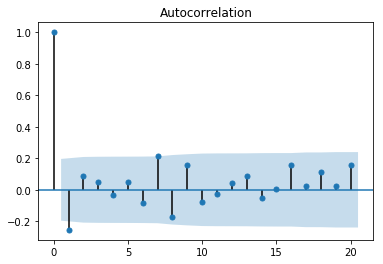

In [32]:
plot_acf(minute[['return']][:100]);

#### Test on stationarity 

In [33]:
#plot_acf(day['return'],lags=1000,zero=False,alpha=0.5,);
adf=adfuller(day['return'],regression='c',autolag='AIC')
print('Daily - ADF - p-value = {}, number of lags = {}'.format(adf[1],adf[2]))
kps=kpss(day['return'],regression='ct')
print('Daily -KPSS - p-value = {}, number of lags = {}'.format(kps[1],kps[2]))
print('----------------------------------------------------')
adf=adfuller(hour['return'],regression='c',autolag='AIC')
print('Hourly - ADF - p-value = {}, number of lags = {}'.format(adf[1],adf[2]))
kps=kpss(hour['return'],regression='ct')
print('Hourly -KPSS - p-value = {}, number of lags = {}'.format(kps[1],kps[2]))
print('----------------------------------------------------')
adf=adfuller(minute['return'][:30000],maxlag=62,regression='ct',autolag='AIC')#since high computational cost
print('Minute - ADF - p-value = {}, number of lags = {}'.format(adf[1],adf[2]))
kps=kpss(minute['return'][:30000],regression='ct')
print('Minute -KPSS - p-value = {}, number of lags = {}'.format(kps[1],kps[2]))

Daily - ADF - p-value = 2.2804103573286786e-13, number of lags = 27
Daily -KPSS - p-value = 0.1, number of lags = 27
----------------------------------------------------
Hourly - ADF - p-value = 1.4642465322092496e-29, number of lags = 35
Hourly -KPSS - p-value = 0.1, number of lags = 39
----------------------------------------------------
Minute - ADF - p-value = 0.0, number of lags = 20
Minute -KPSS - p-value = 0.1, number of lags = 50


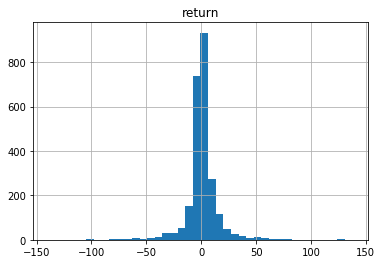

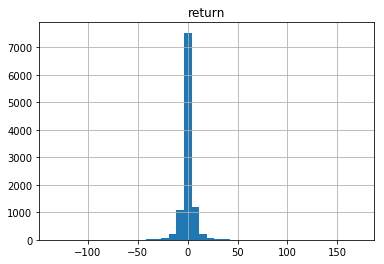

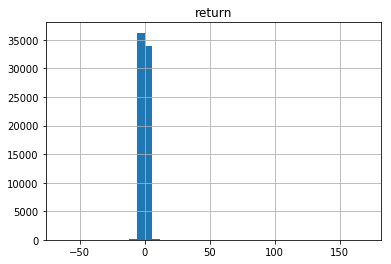

In [34]:
day[['return']].hist(bins=40);#normal?
hour[['return']].hist(bins=40);
minute[['return']].hist(bins=40);

### Data preparation

In [50]:
#count emission matrix based on some characteristic (investor sentiment, for instance)
close_high=day[day['open']<day['close']]
open_high=day[day['open']>day['close']]
close_total=close_high[['size']].count()
open_total=open_high[['size']].count()
group_close=close_high.groupby('size').count()
group_open=open_high.groupby('size').count()
close_pos=group_close.iloc[0,0]
close_neg=group_close.iloc[1,0]
open_pos=group_open.iloc[0,0]
open_neg=group_open.iloc[1,0]

In [51]:
#M=np.array([[open_pos/open_total, open_neg/open_total],[close_pos/close_total, close_neg/close_total]])
M=pd.DataFrame(np.array([[0.3,0.7],[0.8,0.2]]),columns=['P','N'])#emission matrix
M.rename(index={0:'open',1:'close'}, inplace=True)
T=pd.DataFrame(np.array([[0.6,0.4],[0.5,0.5]]), columns=['open','close']) #transition matrix
T.rename(index={0:'open',1:'close'}, inplace=True)
pi_=pd.DataFrame(np.array([0.5,0.5]))#probabilities of initial states 
pi_.rename(index={0:'open',1:'close'}, inplace=True)
seq=['P','P','N'] # sequence
print('emission matrix M')
print(M)
print('--------')
print('transition matrix T')
print(T)
print('--------')
print('probability of initial states pi_')
print(pi_)

emission matrix M
         P    N
open   0.3  0.7
close  0.8  0.2
--------
transition matrix T
       open  close
open    0.6    0.4
close   0.5    0.5
--------
probability of initial states pi_
         0
open   0.5
close  0.5


###  <span style="color:green"> Sequence to be researched - PPNP </span> 

## Forward Algorithm - probability of being at a state at a specific time step

In [52]:
forward=[] #list of probabilities that observation is in particular state
previous_states=[]
alph=0 #index of observation in sequence
while alph<len(seq):
    obs=seq[alph]
    if alph == 0: #initial state
        for init_state in ('close','open'):
            c_init=pi_.loc[init_state,0]*M.loc[init_state,obs]
            previous_states.append(init_state)
            forward.append(c_init)
            
    elif alph == 1:
        state='close'
        c1=forward[alph-2]*T.loc[previous_states[alph-2],state]*M.loc[state,obs]
        c2=forward[alph-1]*T.loc[previous_states[alph-1],state]*M.loc[state,obs]
        previous_states.append(state)
        forward.append(c1+c2)
        
        state2='open'
        c3=forward[alph-4]*T.loc[previous_states[alph-4],state2]*M.loc[state2,obs]
        c4=forward[alph-3]*T.loc[previous_states[alph-3],state2]*M.loc[state2,obs]
        previous_states.append(state2)
        forward.append(c3+c4)
    else:
        state3='close'
        c1=forward[-2]*T.loc[previous_states[-2],state]*M.loc[state,obs]
        c2=forward[-1]*T.loc[previous_states[-1],state]*M.loc[state,obs]
        previous_states.append(state)
        forward.append(c1+c2)
        
        state4='open'
        c3=forward[-2]*T.loc[previous_states[-2],state2]*M.loc[state2,obs]
        c4=forward[-3]*T.loc[previous_states[-3],state2]*M.loc[state2,obs]
        previous_states.append(state2)
        forward.append(c3+c4)
        
    alph+=1
sequence_probability=forward[-1]+forward[-2]
print('Probability (close - open){}'.format(forward))
print('Probability of the sequence is (close - open){}'.format(sequence_probability))

Probability (close - open)[0.4, 0.15, 0.20800000000000002, 0.087, 0.027760000000000003, 0.10933999999999999]
Probability of the sequence is (close - open)0.1371


## Viterbi Algorithm - find the optimal internal states given a sequence of observations

In [53]:
#the same sequence = P,P,N,P
column_names = seq
best_path=[]
states=['open', 'close']
indices=[0,1]
vit=pd.DataFrame(np.zeros((2,len(seq) )),columns=column_names) 
vit.rename(index={0:'open',1:'close'},inplace=True)
for j in range(len(seq)):
    if j==0:
        for s,i in zip(states,indices):
            v1=pi_.loc[s,0]*M.loc[s,seq[j]]
            vit.iloc[i,j]=v1
    else:
        st1='open'
        idx=0
        idx2=1
        v2=vit.iloc[idx,j-1]*T.loc[vit.index.values[idx],st1]*M.loc[st1,vit.columns.values[j]]
        v3=vit.iloc[idx2,j-1]*T.loc[vit.index.values[idx2],st1]*M.loc[st1,vit.columns.values[j]]
        vit.iloc[idx,j]=max(v2,v3)
        
        st2='close'
        v4=vit.iloc[idx,j-1]*T.loc[vit.index.values[idx],st2]*M.loc[st2,vit.columns.values[j]]
        v5=vit.iloc[idx2,j-1]*T.loc[vit.index.values[idx2],st2]*M.loc[st2,vit.columns.values[j]]          
        vit.iloc[idx2,j]=max(v4,v5)
    idx=0
    idx2=1
    st1='open'
    st2='close'
    if vit.iloc[idx,j]>vit.iloc[idx2,j]:
        best_path.append('open')
    else:
        best_path.append('close')
print('The most probable corresponding states are {}'.format(best_path))
vit

The most probable corresponding states are ['close', 'close', 'open']


,P,P,N
open,0.15,0.06,0.056
close,0.40,0.16,0.016


## Baum-Welch Algorithm - tuning HMM

In [54]:
#Compute backward probabilities
final_back_prob=pd.DataFrame(np.array([[1,1]]), columns=['open','close'])
backward=[]
future_states=['open', 'close']
beta=len(seq)-1
while beta>=0:
    obs1=seq[beta]
    if beta == len(seq)-1:
        current_state='open'
        b1=final_back_prob.iloc[0,0]*T.loc[current_state,future_states[-2]]*M.loc[future_states[-2],seq[beta]]
        b2=final_back_prob.iloc[0,1]*T.loc[current_state,future_states[-1]]*M.loc[future_states[-1],seq[beta]]
        backward.append(b1+b2)
        future_states.append(current_state)
        
        current_state='close'
        b3=final_back_prob.iloc[0,0]*T.loc[current_state,future_states[-2]]*M.loc[future_states[-2],seq[beta]]
        b4=final_back_prob.iloc[0,1]*T.loc[current_state,future_states[-1]]*M.loc[future_states[-1],seq[beta]]
        backward.append(b3+b4)
        future_states.append(current_state)
    else:
        current_state='open'
        b1=backward[-2]*T.loc[current_state,future_states[-2]]*M.loc[future_states[-2],seq[beta]]
        b2=backward[-1]*T.loc[current_state,future_states[-1]]*M.loc[future_states[-1],seq[beta]]
        backward.append(b1+b2)
        future_states.append(current_state)
        
        current_state='close'
        b3=backward[-3]*T.loc[current_state,future_states[-3]]*M.loc[future_states[-3],seq[beta]]
        b4=backward[-2]*T.loc[current_state,future_states[-2]]*M.loc[future_states[-2],seq[beta]]
        backward.append(b3+b4)
        future_states.append(current_state)
        
    beta-=1
print('Backward probabilities are (open - close){}'.format(backward))

Backward probabilities are (open - close)[0.5, 0.44999999999999996, 0.23399999999999999, 0.255, 0.12372, 0.1371]


In [55]:
backward1=backward.copy()
forward1=forward.copy()
gamma=[]
backward.reverse()
backward.extend([final_back_prob.iloc[0,0],final_back_prob.iloc[0,1]])
forward.insert(0,pi_.iloc[0,0])
forward.insert(0,pi_.iloc[1,0])
for symb in range((len(seq)+1)*2):
    gamma.append(backward[symb]*forward[symb])
gamma # numbers at even places are for close, at odd - for open

[0.06855,
 0.06186,
 0.10200000000000001,
 0.0351,
 0.0936,
 0.0435,
 0.027760000000000003,
 0.10933999999999999]

In [56]:
gamma_total=[]
for g in range(0,len(gamma),2):
    gamma_total.extend([gamma[g]+gamma[g+1],gamma[g]+gamma[g+1]])
gamma_final=[x/y for x, y in zip(gamma, gamma_total)]
gamma_final

[0.5256498734759605,
 0.4743501265240396,
 0.7439824945295406,
 0.25601750547045954,
 0.6827133479212254,
 0.3172866520787746,
 0.20247994164843183,
 0.7975200583515681]

In [57]:
cl_back=[]
op_back=[]
cl_forw=[]
op_forw=[]
for i in range(0,len(backward1),2):
    op_back.append(backward1[i])
for j in range(1,len(backward1),2):
    cl_back.append(backward1[j])
    
for i in range(0,len(forward1),2):
    cl_forw.append(forward1[i])
for j in range(1,len(forward1)+1,2):
    op_forw.append(forward1[j])


In [58]:
#cl_back.reverse()
#op_back.reverse()
fb=np.array([cl_back,op_back,cl_forw,op_forw])
forw_back=pd.DataFrame(fb, columns=seq)
forw_back.rename(index={0:'close_b',1:'open_b',2:'close_fw',3:'open_fw'}, inplace=True)
forw_back

,P,P,N
close_b,0.45,0.255,0.13710
open_b,0.50,0.234,0.12372
close_fw,0.40,0.208,0.02776
open_fw,0.15,0.087,0.10934


In [59]:
epsilon=[]
states=['close','open']
for letter in range(len(seq)):
    for s1 in (2,3):
        for s2 in (0,1):
            e=forw_back.iloc[s1,letter]*T.loc[states[s1-2],states[s2-2]]*M.loc[states[s2],seq[letter]]*forw_back.iloc[s2,letter]
            epsilon.append(e)

xi=[]
denom=[]
for i in range(0,len(epsilon),4):
    s1=epsilon[i]+epsilon[i+1]
    s2=epsilon[i+2]+epsilon[i+3]
    s3=s1+s2
    denom.extend([s3,s3,s3,s3])
for j in range(len(epsilon)):
    xi.append(epsilon[j]/denom[j])
xi

[0.525164113785558,
 0.2188183807439825,
 0.15754923413566738,
 0.09846827133479212,
 0.5401161494117683,
 0.18586349847404968,
 0.1807311730723994,
 0.0932891790417826,
 0.04496854272084154,
 0.1420297474032006,
 0.14169626689039808,
 0.6713054429855598]

In [60]:
##new parameters
pi_=gamma_final[:2]
pi_

[0.5256498734759605, 0.4743501265240396]

In [61]:
gam_close=[]
gam_open=[]
for a in range(1,len(gamma_final),2):
    gam_open.append(gamma_final[a])
for b in range(0,len(gamma_final),2):
    gam_close.append(gamma_final[b])
nam=['0']+seq
gam=np.array([gam_open,gam_close])
gam_state=pd.DataFrame(gam,columns=nam)
gam_state.rename(index={0:'open',1:'close'},inplace=True)
g1=gam_state.iloc[0,:-1].sum()#open
g2=gam_state.iloc[1,:-1].sum()#close
g_total1=gam_state.iloc[0,:].sum()
g_total2=gam_state.iloc[1,:].sum()
gam_state

,0,P,P,N
open,0.47435,0.256018,0.317287,0.79752
close,0.52565,0.743982,0.682713,0.20248


In [62]:
op_cl=[]
op_op=[]
cl_op=[]
cl_cl=[]
for u in range(0,len(xi),4):
    cl_cl.append(xi[u])
    cl_op.append(xi[u+1])
    op_cl.append(xi[u+2])
    op_op.append(xi[u+3])
tran=np.array([op_op,op_cl,cl_cl,cl_op])
trans=pd.DataFrame(tran,columns=seq)
trans.rename(index={0:'op_op',1:'op_cl',2:'cl_cl',3:'cl_op'},inplace=True)
trans

,P,P,N
op_op,0.098468,0.093289,0.671305
op_cl,0.157549,0.180731,0.141696
cl_cl,0.525164,0.540116,0.044969
cl_op,0.218818,0.185863,0.142030


In [63]:
t1=trans.iloc[0,:-1].sum()/g1
t2=trans.iloc[1,:-1].sum()/g1
t3=trans.iloc[2,:-1].sum()/g2
t4=trans.iloc[3,:-1].sum()/g2
T=pd.DataFrame(np.array([[t1,t2],[t4,t3]]),columns=['open','close'])
T.rename(index={0:'open',1:'close'},inplace=True)
T#new transition matrix

,open,close
open,0.183035,0.322893
close,0.207280,0.545641


In [64]:
#new emission matrix
m1=gam_state.loc['open','P'].sum()/g_total1
m2=gam_state.loc['open','N'].sum()/g_total1
m3=gam_state.loc['close','P'].sum()/g_total2
m4=gam_state.loc['close','N'].sum()/g_total2
emis=np.array([[m1,m2],[m3,m4]])
M=pd.DataFrame(emis,columns=['P','N'])
M.rename(index={0:'open',1:'close'},inplace=True)
M

,P,N
open,0.310705,0.432219
close,0.662093,0.093966


In [65]:
class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.8 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]
            
btscv = BlockingTimeSeriesSplit(n_splits=5)

ADF - p-value = 7.971217135806521e-17, number of lags = 17
KPSS - p-value = 0.01, number of lags = 27
